In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import matplotlib as mpl
from math import factorial, ceil

# Choose which version of the program to run and analyze

In [7]:
#which = ''
which = '_new'

# Script

In [14]:
ofdir = './precision_study/dx'
dims = [2**i for i in range(3,10)]
xlims = [dim**0.5*np.array((-1, 1)) for dim in dims] if which=='' else [(-5, 5) for i in dims]
precision = 0.1

In [15]:
for i, dim in enumerate(tqdm(dims)):
    os.system(f"./exercise04{which} -k {dim}" + f' -p {precision}' + f" -x {xlims[i][0]},{xlims[i][1]}"+ " -o " + ofdir + str(dim))

100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


# Study precision
For the hamiltonian hardcoded in the program we expect to have as eigenvalues $\lambda = (2n+1)$ with $n\in\mathbb{N}$. Thus we can get the relative error for each eigenvalue.

In [16]:
data = np.loadtxt(f'{ofdir}{dims[-1]}{which}.txt')
eigenstates = data[:-1,:]
eigenvalues = data[-1,:]
x = list(range(len(eigenvalues)))
truevals = [2*i+1 for i in range(len(eigenvalues))]
error = abs(eigenvalues - truevals)/truevals

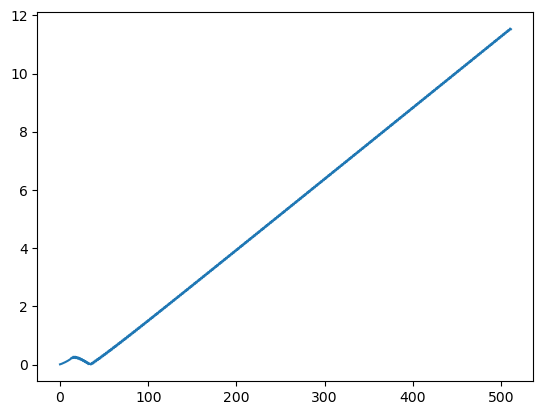

In [17]:
plt.plot(x, error)

## Read data

In [12]:
tot_truevals = [2*i+1 for i in range(dims[-1])]
errors = []
eigenvalues_dim = []
eigenstates_dim = []
for dim in dims:
    data = np.loadtxt(ofdir + f'{dim}{which}.txt')
    eigenvalues = data[-1,:]
    eigenstates = data[:-1, :]
    eigenvalues_dim.append(eigenvalues)
    eigenstates_dim.append(eigenstates)
    truevals = tot_truevals[:dim]
    error = abs(eigenvalues - truevals)/truevals
    errors.append(error)


## Analyze data

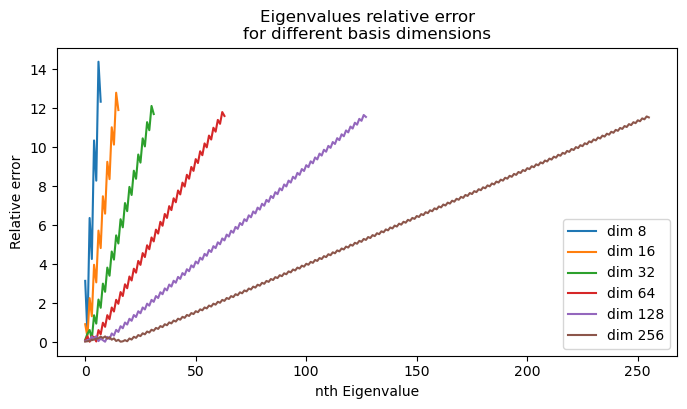

In [13]:
fig, ax = plt.subplots(figsize = (8, 4))
for i, dim in enumerate(dims):
    ax.plot(np.arange(dim), errors[i], label=f'dim {dim}')
ax.legend()
ax.set_title("Eigenvalues relative error\nfor different basis dimensions")
ax.set_xlabel('nth Eigenvalue')
ax.set_ylabel('Relative error')
fig.savefig(f'relative_error{which}.svg')

In [388]:
print('linearity holds till relativ error:', max(errors[-1][100:200]))

linearity holds till relativ error: 0.05153161455318593


array([ 0.12090946, -0.83191325])

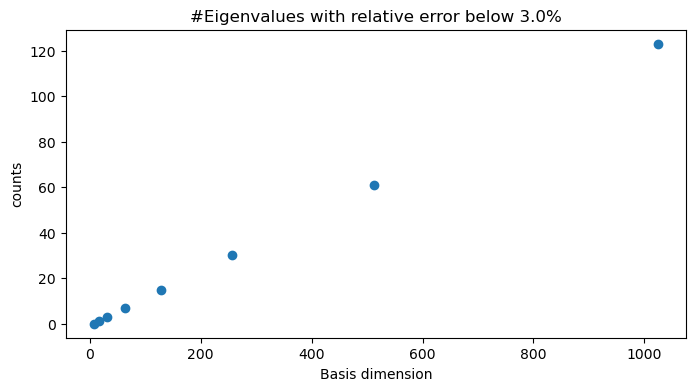

In [389]:
threshold = 0.03
neigval_belowt = [len(error[error < threshold]) for error in errors]

fig, ax = plt.subplots(figsize = (8, 4))
ax.scatter(dims, neigval_belowt)
#ax.set_xscale(mpl.scale.LogScale(axis='x', base=2))
#ax.set_yscale('log')
ax.set_title(f"#Eigenvalues with relative error below {threshold*100}%")
ax.set_xlabel('Basis dimension')
ax.set_ylabel('counts')
fig.savefig(f'neigenbelow1{which}.svg')
np.polyfit(dims, neigval_belowt, deg=1)

Text(0, 0.5, 'ang_coeffs')

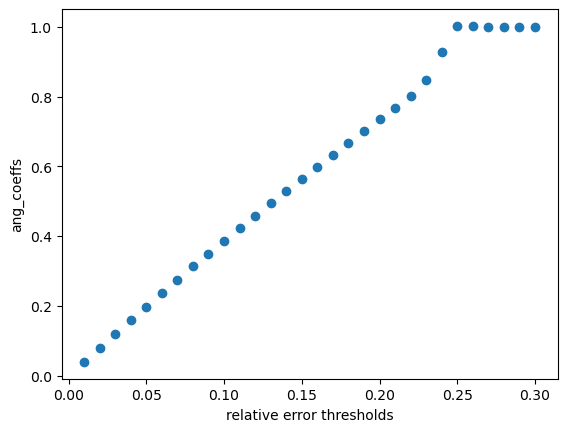

In [390]:
thresholds = [i*0.01 for i in range(1, 31)]
ang_coeffs = np.asarray([np.polyfit(dims, [len(error[error < threshold]) for error in errors], deg=1)[0] for threshold in thresholds])
plt.scatter(thresholds, ang_coeffs, label='data')
plt.xlabel('relative error thresholds')
plt.ylabel('ang_coeffs')

## Focus in the interval 0-3%

[ 4.02009711e+00 -3.47493360e-04]


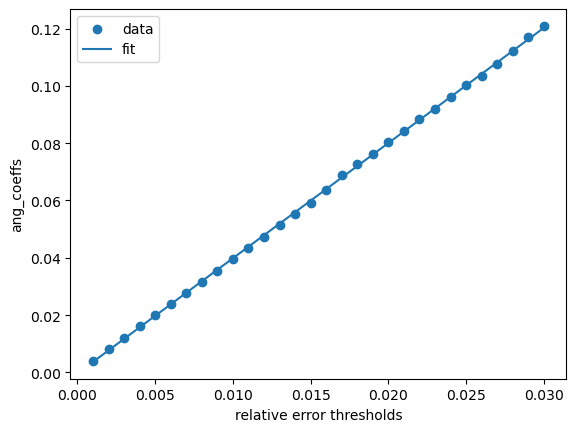

In [391]:
thresholds = [i*0.001 for i in range(1, 31)]
ang_coeffs = np.asarray([np.polyfit(dims, [len(error[error < threshold]) for error in errors], deg=1)[0] for threshold in thresholds])
plt.scatter(thresholds, ang_coeffs, label='data')
plt.xlabel('relative error thresholds')
plt.ylabel('ang_coeffs')

coeffs = np.polyfit(thresholds, ang_coeffs, deg=1)
print(coeffs)
plt.plot(thresholds, coeffs[0]*np.asarray(thresholds) + coeffs[1], label='fit')
plt.legend()

Thus we get that for precision below 3% the following holds:
$$
    k = \frac{k_{user}}{10 * precision}
$$
where $k$ is the number of points in the discretized space and $k_{user}$ is the number of eigenvalues the user wabts to get

# Study eigenstates

In [8]:
def th_eigenstates(E_level):
    hermite_coeffs = np.zeros(E_level+1)
    hermite_coeffs[-1] = 1
    hermite = np.polynomial.hermite.Hermite(coef=hermite_coeffs, )
    if E_level>50:
        return lambda x: np.exp(-0.5*(E_level*np.log(2)+E_level*(np.log(E_level)-1)+0.5*np.log(np.pi)+x**2))*hermite(x)
    else:
        return lambda x: (2**E_level*factorial(E_level)*np.pi**0.5)**-0.5*np.exp(-x**2/2)*hermite(x)

100%|██████████| 4/4 [00:00<00:00, 1388.04it/s]


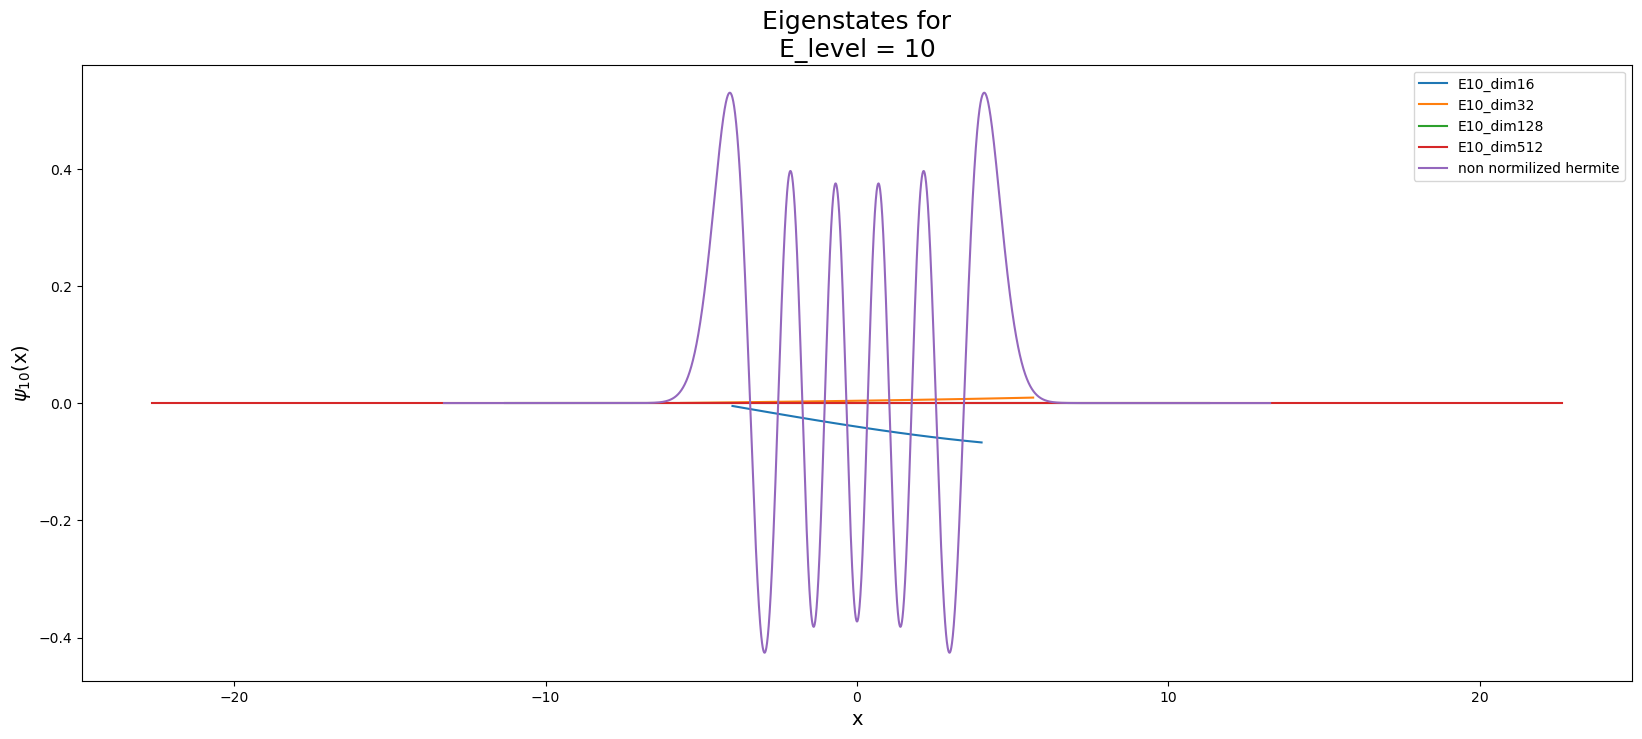

In [10]:

fig, ax = plt.subplots(figsize=(20, 8))
E_level = 10
th_eigenstate = th_eigenstates(E_level)
for i in tqdm(np.linspace(np.where(np.array(dims)>E_level)[0][0], len(dims), 4, endpoint=False,dtype=np.int16)):
    x, step = np.linspace(xlims[i][0], xlims[i][1], ceil(dims[i]/(10*precision if which != '' else 1)), endpoint=True, retstep=True)
    if step == 0:
        print('step=0 at dim:', dim[i])
        continue
    if which != '':
        x = x*dims[i]**0.5
    ax.plot(x, eigenstates_dim[i][:, E_level], label=f'E{E_level}_dim{dims[i]}')

x_hermite, step_h = np.linspace(-4, 4, 6000, endpoint=True, retstep=True)
x_hermite = x_hermite*(E_level+1)**0.5
#hermite_norm = np.sqrt(sum(th_eigenstate(x_hermite)**2))
x_max = abs(x_hermite[np.argmax(th_eigenstate(x_hermite))])
ax.plot(x_hermite, th_eigenstate(x_hermite), label='non normilized hermite')
ax.set_title(f'Eigenstates for\nE_level = {E_level}', size=18)
ax.set_xlabel('x', size=14)
ax.set_ylabel('$\psi_{' + str(E_level) + '}$(x)', size=14)
#ax.set_xlim(-x_max-5, x_max+5)
ax.legend()
fig.savefig(f'eigenstates{which}.svg')


  0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_2783/1401707011.py:8: RuntimeWarning: overflow encountered in long_scalars
  return lambda x: (2**E_level*factorial(E_level)*np.pi**0.5)**-0.5*np.exp(-x**2/2)*hermite(x)
/tmp/ipykernel_2783/1401707011.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return lambda x: (2**E_level*factorial(E_level)*np.pi**0.5)**-0.5*np.exp(-x**2/2)*hermite(x)
 57%|█████▋    | 147/256 [00:00<00:00, 1457.28it/s]/media/alberto/Volume/Kubuntu/miniconda3/envs/torch/lib/python3.10/site-packages/numpy/polynomial/hermite.py:895: RuntimeWarning: overflow encountered in multiply
  return c0 + c1*x2
/tmp/ipykernel_2783/703850491.py:11: RuntimeWarning: invalid value encountered in true_divide
  y_plot.append(sum(abs(th_eigenstate(x)/hermite_norm-eigenstates_dim[i][:,E_level]))*step/dim)
/media/alberto/Volume/Kubuntu/miniconda3/envs/torch/lib/python3.10/site-packages/numpy/polynomial/hermite.py:894: RuntimeWarning: overflow encountered in multipl

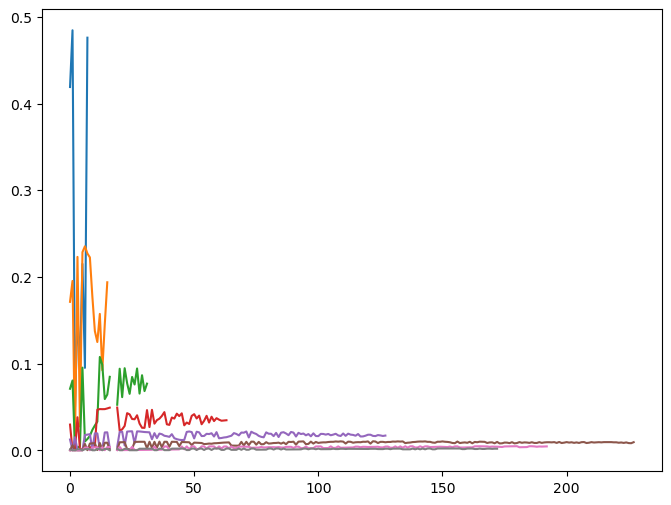

In [397]:
fig, ax = plt.subplots(figsize=(8, 6))
for i, dim in enumerate(dims):
    x, step = np.linspace(xlims[i][0], xlims[i][1], ceil(dim/(10*precision if which != '' else 1)), endpoint=True, retstep=True)
    if which != '':
        x = x/np.sqrt(step)
    x_plot = np.arange(dim)
    y_plot = []
    for E_level in tqdm(x_plot):
        th_eigenstate = th_eigenstates(E_level)
        hermite_norm = np.sqrt(sum(th_eigenstate(x)**2))
        y_plot.append(sum(abs(th_eigenstate(x)/hermite_norm-eigenstates_dim[i][:,E_level]))*step/dim)

    ax.plot(x_plot, y_plot, label=f'dim {dim}')

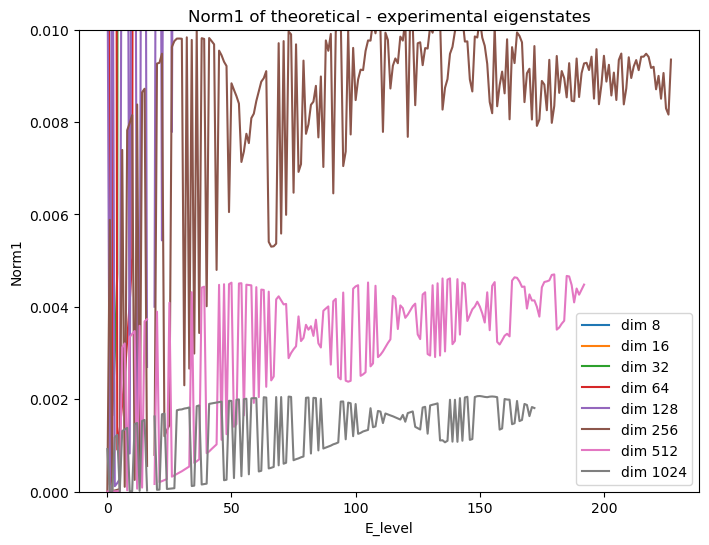

In [398]:
ax.legend()
ax.set_xlabel('E_level')
ax.set_ylabel('Norm1')
ax.set_title('Norm1 of theoretical - experimental eigenstates')
ax.set_ylim(0, 0.01)
fig.savefig(f'norm1{which}.svg')
fig

# Check normalization

In [130]:
print('check normalization:')
for i, dim in enumerate(dims):
    print(f'dim {dim}', np.allclose(np.sum(eigenstates_dim[i]**2, axis=0), [1.]))

check normalization:
dim 2 True
dim 4 True
dim 8 True
dim 16 True
dim 32 True
dim 64 True
dim 128 True
dim 256 True
dim 512 True
